# **Initial Setting**

## 0. Import packages

In [2]:
!pip install emnist
# dataset
from emnist import list_datasets
from emnist import extract_training_samples

# complement
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import logging
import random
import time
import os
from scipy.special import softmax

# tensorflow
import keras
import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras import backend as K
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

# sklearn
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

## 1. Setup dataset

In [23]:
class datasetSetup:
  def __init__(self, verbose=False):
    self.mode = "MNIST"
    self.verbose = verbose
    self.images, self.labels = self.downloadEmnist()
    self.check = [0] * self.labels.shape[0]
    # num of clients in each region
    self.num_of_clients = [1, 100, 100, 100]

  def downloadMNIST(self):
    (train_X, train_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
    if self.verbose == True:
      logging.infor(train_X.shape, train_y.shape)
    return train_X, train_y, test_X, test_y

  def downloadEmnist(self):
    images, labels = extract_training_samples('balanced')
    if self.verbose == True:
      logging.info(images.shape, labels.shape)
    return images, labels      

  def preProcessData(self, N_user):
    # Train-Test
    if (self.mode == "MNIST"):
      self.X_train, self.y_train, self.X_test, self.y_test = self.downloadMNIST()  
      print(len(self.X_train))
      print(len(self.X_test))
    elif (self.mode == EMNIST):
      x, y = self.downloadEmnist()
      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(x, y, test_size=0.05, random_state=42)
      
    # Data Normalization
    raw_dataset_for_iid  = list(zip(self.X_train.reshape(-1, 28, 28, 1).astype("float32")/255.0, self.y_train.astype("float32")))
    test_dataset_for_iid = [self.X_test.reshape(-1, 28, 28, 1).astype("float32")/255.0, self.y_test.astype("float32")]
    random.shuffle(raw_dataset_for_iid)

    # Check X_train total data + split by number of user:
    total_samples = len(self.X_train)
    num_of_samples = total_samples/N_user
   
    # Assign data to clients
    temp_list_for_image=[]
    temp_list_for_label=[]
    federated_train_data_for_iid = []
    federated_test_data_for_iid = []
    for idx, el in enumerate(raw_dataset_for_iid) :
        temp_list_for_image.append(el[0])
        temp_list_for_label.append(el[1])
        if (idx+1)%(num_of_samples)==0 :
            federated_train_data_for_iid.append((np.array(temp_list_for_image, dtype="float32"), np.array(temp_list_for_label, dtype="float32")))
            temp_list_for_image=[]
            temp_list_for_label=[]    

    federated_test_data_for_iid = test_dataset_for_iid

    return federated_train_data_for_iid, federated_test_data_for_iid

  def visualizeData(self, image):
    for i in range(9):
      # define subplot
      plt.subplot(330 + 1 + i)
      # plot raw pixel data
      plt.imshow(image[i].reshape(28,28))
      # show the figure
    plt.show()    

# **Federated Learning Definition**




## BaseNetwork

In [11]:
class BaseNetwork(Model):
  def __init__(self):
    super(BaseNetwork,self).__init__()
    self.mode = "MNIST"
    if (self.mode == "MNIST"):
      self.predictor= tf.keras.models.Sequential([
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(128, kernel_size=(5, 5), activation="relu", padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),        
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),        

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(10, name = "logits"),
        tf.keras.layers.Activation('softmax')
        ])
    elif (self.mode == "EMNIST"):
      self.predictor= tf.keras.models.Sequential([
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(128, kernel_size=(5, 5), activation="relu", padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),        
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),        

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(47, name = "logits"),
        tf.keras.layers.Activation('softmax')
        ])

  def call(self, x):
    predictor = self.predictor(x)
    return predictor

# **Channel Environment**

In [48]:
class FL_Environment:
  def __init__(self,
               areaR, x_0, y_0, N_user,                 # Area settings
               P_user, B_user,                          # User settings
               P_server, B_server,                      # Server settings
               fraction, total_user,                    # FL settings
               samples_region_train,
               samples_region_test,
               batch_size = 32, epochs = 50,
               verbose=True
               ):

    # FL dataset
    self.samples_region_train = samples_region_train
    self.samples_region_test  = samples_region_test
    # Aggregated model initialization
    self.server_aModel = BaseNetwork()
    self.server_aModel.predictor.compile(optimizer = 'adam',
                                         loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                         metrics = ['accuracy'])

    # FL client settings: 
    self.regional_dModel = BaseNetwork()
    self.regional_dModel.predictor.compile(optimizer = 'adam',
                                           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                           metrics = ['accuracy'])
    self.total_clients = len(samples_region_train)
    self.selected_clients = int(self.total_clients*fraction)                       

    # Area settings
    self.R = areaR
    self.N = N_user
    self.B_user = B_user
    # Server settings
    self.x_0 = x_0
    self.y_0 = y_0
    # self.userList_Radius = []
    # self.userList_Angle = []
    self.userList_x = []
    self.userList_y = []
    self.userList_location = []
    
    # General settings 
    self.shuffle_per_round = True 
    self.vers = verbose
    if self.vers == True:
      self.regional_dModel.predictor.summary()
    self.batch_size = batch_size
    self.epochs = epochs                       

  def _clientInit(self, ):
    for user_no in range(self.N):
      user_Radius = random.uniform(50, self.R)
      user_Angle  = 360*user_no/int(self.N)+random.uniform(-5, 5)
      user_x = self.x_0 + user_Radius * math.cos(math.radians(user_Angle))
      user_y = self.y_0 + user_Radius * math.sin(math.radians(user_Angle))

      self.userList_x.append(user_x)
      self.userList_y.append(user_y)
      self.userList_location.append((user_x, user_y))
    # Client Plot
    fig, ax = plt.subplots()                                                   
    circle1 = plt.Circle((self.x_0, self.y_0), self.R, color='b', fill=False) 
    circle2 = plt.Circle((self.x_0, self.y_0), 1, color='r', fill=True)       
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    print(f"List of user location is: {self.userList_location}")
    plt.scatter(self.userList_x, self.userList_y)
    plt.show()

  """
     Federated Learning Process   
  """
  def _clientTrain(self, global_params):
    list_of_local_parameter=[]       # Distributed model   
    list_of_local_dataset_size=[]    # Distributed model   
    list_of_local_accuracy=[]        # Distributed model   
    list_of_local_loss=[]            # Distributed model  
    if self.vers == True: 
      print("\n▶ Round", round+1, "◀")
    # check whether to apply shuffle mode per round
    if self.shuffle_per_round == True:
      selected_clients_list = np.random.choice(self.total_clients, size=self.selected_clients, replace=False) 

    for client_idx in selected_clients_list:
      # get data for each cliente
      train_images, train_labels = self.samples_region_train[client_idx]
      # update teacher params
      self.regional_dModel.predictor.set_weights(global_params)
      print("=====================")
      print(f"train label is: {train_labels.shape}")
      train_result = self.regional_dModel.predictor.fit(train_images,
                                                       train_labels,
                                                       self.batch_size,
                                                       self.epochs)
      print("=====================")
      list_of_local_parameter.append(self.regional_model.predictor.get_weights())
      list_of_local_dataset_size.append(len(train_images))
      list_of_local_accuracy.append(train_result.history["accuracy"][-1])
      list_of_local_loss.append(train_result.history["loss"][-1])

    return list_of_local_parameter, list_of_local_dataset_size, list_of_local_accuracy, list_of_local_loss

  def _ServerAggregate(self, list_of_local_parameter, list_of_local_dataset_size, list_of_local_accuracy, list_of_local_loss):
    self.global_parameter = np.mean(list_of_local_parameter, axis=0)
    current_mean_accuracy = np.mean(np.array(list_of_local_accuracy, dtype="float32"))
    current_mean_loss = np.mean(np.array(list_of_local_loss, dtype="float32"))
    if self.vers == True:
      print(f"  evaluation mean : accuracy - {current_mean_accuracy}, loss - {current_mean_loss}")
      self.server_aModel.predictor.set_weights(global_params)
      self.server_aModel.predictor.evaluate(x = self.samples_region_test[0], y = self.samples_region_test[1])
    return self.global_parameter

  ####################################################################################################
  """
     Channel Propagation Process   
  """
  def client2server_env(self, dataModel):
    self.OTAtrigger = False
    """
      If OTA FL, accuracy reduce, we use it here later
    """
    return dataModel
  
  ### =============================== ###
  def server2client_env(self, dataModel):
    self.OTAtrigger = False
    """
      If OTA FL, accuracy reduce, we use it here later
    """
    if heterModel: 
      pass
    else: 
      return dataModel

    return dataModel


  ####################################################################################################
        ######################################################################################
  def _propagationLoss(self):
    """
    Parameters:
    ===========
      userList_distance: List of user's distance, calculated by norm-2 between user and server 
    ===========
    """
    userList_distance = []            
    # init BS location:               
    bs_location = (self.x_0, self.y_0)

    for user_no in range(self.N):
      user_distance     = np.linalg.norm(np.array(self.userList_location[user_no]) - np.array(bs_location))
      userList_distance.append(user_distance)
    print(f"List of user distance is: {userList_distance}")
    self.userList_pathloss = 140.7 + 36.7 * np.log10(userList_distance)

    return self.userList_pathloss, userList_distance

  def _channelGain(self):
    self.heterModel = False
    """
      If heterogeneous model, accuracy reduce, we use it here later
    """
    if self.heterModel: 
      self.userList_H = self.userList_pathloss  
    else: 
      self.userList_H = self.userList_pathloss   

    return self.userList_H

        ######################################################################################
  def _dataRate(self, bandwidth, channel, powerBS, powerUser, noise):
    self.total_bandwidth = bandwidth
    self.resource_coeff  = np.array(channel)
    self.powerBS         = powerBS
    self.powerUser       = np.array(powerUser)
    self.noise           = noise

    userList_datarate = abs(self.total_bandwidth * self.resource_coeff * 
                            np.log2(1 + ((self.powerUser * self.userList_H) / 
                                          (self.noise * self.resource_coeff + self.powerBS * self.userList_H))))

    return userList_datarate

# **Federated Learning Process**

## FL Initialization

60000
10000
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 64)        204864    
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               1606144   
_________________________________________________________________
logits (Dense)               (None, 10)  

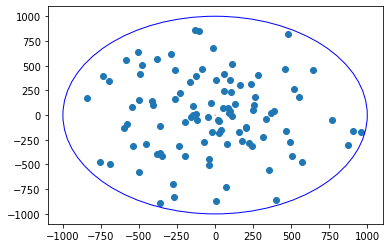

List of user distance is: [766.8014391781306, 388.0368533314029, 370.5900548345036, 256.20749548712456, 91.38148388397347, 580.29559882195, 270.7817129217859, 106.07962295479197, 581.623118602567, 320.7194729108959, 106.78629868796105, 790.3614071065638, 170.280148569097, 653.42855022676, 489.44799144210816, 88.30956425239957, 396.23117118063783, 948.2070506766682, 347.4324220591593, 258.3845480740348, 252.02049305642512, 367.396659294187, 420.56450678881896, 527.0336449212236, 354.7365955603569, 675.2359810659123, 873.794461900463, 859.1430404965746, 125.18928482587519, 469.68869149617285, 414.78463456905035, 374.1542657571827, 528.1712424697166, 684.7030807003912, 681.4902127837347, 811.9699021981764, 698.363322953956, 809.8370370403147, 325.2625053943605, 643.472605370806, 170.36404133190024, 309.06133736594126, 835.815180817974, 774.1808226620224, 441.57665335333456, 525.4455909333711, 859.1331828196701, 417.6171083339324, 554.182275095128, 126.38941000587923, 148.40308771354273, 1

In [49]:
fraction = 0.1
total_user = 100

################################## Initialization ####################################
bandwidth = 20*(10**6)
resource_coeff = []
for user_no in range(total_user):
  resource_coeff.append(1/(fraction*total_user))
powerBS = 100
powerUser = 5
noise = 5
TRAINING_ROUNDS = 5
initModel = BaseNetwork()
get_serverModel = initModel.predictor.get_weights()

######################################################################################
dataset = datasetSetup()
federated_train_data_for_iid, federated_test_data_for_iid = dataset.preProcessData(total_user)
######################################################################################
FL_Env = FL_Environment(areaR = 1000, N_user = 100, P_user = 1, B_user = 2, P_server = 3, B_server = 4, x_0 = 0, y_0 = 0,
                        fraction = fraction, total_user = total_user,
                        samples_region_train = federated_train_data_for_iid, samples_region_test = federated_test_data_for_iid)
FL_Env._clientInit()
setPathloss, setDistance = FL_Env._propagationLoss()
setChannelGain = FL_Env._channelGain()
setDatarate = FL_Env._dataRate(bandwidth= bandwidth, channel= resource_coeff, 
                               powerBS= powerBS, powerUser= noise, noise= noise)
print(f"List of user distance is: {setDistance}")         
print(f"List of user path loss is: {setPathloss}")        
print(f"List of user channel gain is: {setChannelGain}")  
print(f"List of user data rate is: {setDatarate}")        



In [33]:
print(len(federated_train_data_for_iid))
print(len(federated_test_data_for_iid[0]))

100
10000


## FL Process

In [50]:
for round in range(TRAINING_ROUNDS) :
# Client Side
  # Train client
  sent_clientModel = FL_Env._clientTrain(get_serverModel)    
  # Update Client2Server
  # Client2Server Propagating
  get_clientModel, get_clientSize, get_clientAccuracy, get_clientLoss = FL_Env.client2server_env(sent_clientModel)  

  ########### ########### ###########
  # Server retrieval

  # Server Aggregation        
  sent_serverModel = FL_Env._ServerAggregate(get_clientModel, get_clientSize, get_clientAccuracy, get_clientLoss)   
  # Update Server2Client      
  # Server2Client Propagating
  get_serverModel = FL_Env.server2client_env(sent_serverModel)


▶ Round 1 ◀
train label is: (600,)
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


19/19 [==============================] - 16s 6ms/step - loss: 1.4610 - accuracy: 0.5050
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.3884 - accuracy: 0.8717
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.2094 - accuracy: 0.9300
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.9833
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0398 - accuracy: 0.9917
Epoch 6/50
19/19 [==============================] - 0s 18ms/step - loss: 0.0117 - accuracy: 0.9983
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9983
Epoch 8/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0104 - accuracy: 0.9983
Epoch 9/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0217 - accuracy: 0.9917
Epoch 10/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0200 - accuracy: 0.9933
Epoch 11/50
19/19 [=========

AttributeError: ignored

In [46]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data() # This dataset is not "E"mnist. Don't confuse!
print(mnist_test[1].shape)
raw_dataset_for_iid=list(zip(mnist_train[0].reshape(-1, 28, 28, 1).astype("float32")/255.0, mnist_train[1].astype("float32")))
loop_number = 2

random.shuffle(raw_dataset_for_iid)

el_size=600
temp_list_for_image=[]
temp_list_for_label=[]
federated_train_data_for_iid=[]
for idx, el in enumerate(raw_dataset_for_iid) :
    temp_list_for_image.append(el[0])
    temp_list_for_label.append(el[1])
    if (idx+1)%(el_size)==0 :
        federated_train_data_for_iid.append((np.array(temp_list_for_image, dtype="float32"), np.array(temp_list_for_label, dtype="float32")))
        temp_list_for_image=[]
        temp_list_for_label=[]

federated_train_data = federated_train_data_for_iid

print("\n▶ Round", round+1, "◀")

    # check whether to apply shuffle mode per round
selected_clients_list = np.random.choice(100, size=10, replace=False)

for client_dataset in selected_clients_list :
    train_images, train_labels=federated_train_data[client_dataset]
    print(train_labels)
    

(10000,)

▶ Round 1 ◀
[1. 7. 5. 1. 9. 6. 1. 2. 6. 7. 4. 7. 0. 3. 5. 5. 2. 7. 1. 8. 1. 0. 8. 0.
 1. 3. 1. 1. 3. 8. 1. 7. 8. 0. 2. 4. 5. 2. 2. 5. 8. 8. 8. 1. 6. 5. 7. 5.
 6. 1. 5. 2. 7. 0. 1. 4. 5. 3. 7. 2. 4. 1. 8. 3. 7. 5. 6. 6. 3. 4. 2. 1.
 4. 1. 9. 3. 1. 8. 4. 1. 1. 0. 0. 7. 2. 8. 7. 7. 3. 9. 3. 4. 8. 1. 0. 8.
 5. 6. 3. 6. 7. 2. 3. 7. 5. 9. 6. 1. 1. 9. 1. 0. 3. 0. 9. 4. 7. 9. 7. 3.
 1. 7. 3. 9. 4. 3. 8. 2. 4. 2. 0. 8. 8. 0. 4. 6. 4. 0. 1. 9. 1. 9. 1. 0.
 9. 0. 3. 1. 0. 9. 4. 4. 4. 8. 5. 7. 0. 7. 1. 3. 7. 9. 3. 5. 0. 3. 1. 3.
 9. 5. 3. 7. 4. 1. 3. 1. 4. 9. 5. 9. 3. 0. 7. 9. 5. 1. 4. 4. 4. 2. 6. 1.
 3. 8. 8. 8. 2. 0. 4. 2. 4. 8. 6. 3. 0. 6. 5. 6. 5. 6. 8. 3. 3. 3. 0. 4.
 7. 0. 0. 8. 8. 6. 0. 3. 6. 6. 2. 9. 9. 6. 9. 8. 0. 6. 0. 7. 1. 9. 5. 8.
 0. 3. 8. 3. 6. 7. 9. 6. 2. 8. 1. 1. 7. 1. 7. 7. 3. 4. 6. 4. 9. 9. 2. 2.
 0. 5. 8. 2. 7. 9. 3. 8. 4. 7. 2. 9. 2. 2. 1. 1. 4. 5. 5. 4. 6. 4. 1. 1.
 1. 3. 6. 3. 8. 0. 6. 5. 6. 8. 2. 2. 1. 8. 2. 1. 3. 8. 8. 6. 2. 8. 7. 9.
 0. 0. 6. 2. 0. 7. 3. 7. 1. 4